<a href="https://colab.research.google.com/github/Sudha-Jennifer/DL/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat


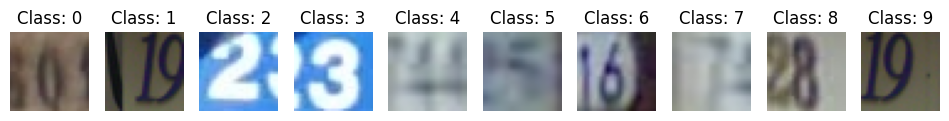

Epoch 1/10, Loss: 1.2306, Val Accuracy: 0.6915
Epoch 2/10, Loss: 0.9213, Val Accuracy: 0.7313
Epoch 3/10, Loss: 0.8361, Val Accuracy: 0.7465
Epoch 4/10, Loss: 0.7821, Val Accuracy: 0.7601
Epoch 5/10, Loss: 0.7414, Val Accuracy: 0.7610
Epoch 6/10, Loss: 0.7136, Val Accuracy: 0.7649


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

def load_svhn(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197))
    ])

    train_dataset = datasets.SVHN(root='./data', split='train', transform=transform, download=True)
    test_dataset = datasets.SVHN(root='./data', split='test', transform=transform, download=True)

    val_size = int(0.1 * len(train_dataset))
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def plot_sample_images(dataset, num_classes=10):
    fig, axes = plt.subplots(1, num_classes, figsize=(12, 2))
    for i in range(num_classes):
        idx = np.where(dataset.labels == i)[0][0]
        img = dataset.data[idx].transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {i}')
        axes[i].axis('off')
    plt.show()

class FeedforwardNN(nn.Module):
    def __init__(self, input_size=3072, hidden_layers=[64, 64], output_size=10, activation='relu', weight_init='xavier'):
        super(FeedforwardNN, self).__init__()
        layers = []
        prev_size = input_size
        for h in hidden_layers:
            layer = nn.Linear(prev_size, h)
            if weight_init == 'xavier':
                nn.init.xavier_uniform_(layer.weight)
            elif weight_init == 'random':
                nn.init.uniform_(layer.weight)
            layers.append(layer)
            layers.append(nn.ReLU() if activation == 'relu' else nn.Sigmoid())
            prev_size = h

        layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten images
        return self.model(x)

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_acc = evaluate_model(model, val_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}')

def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return accuracy_score(all_labels, all_preds)

def plot_confusion_matrix(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

train_loader, val_loader, test_loader = load_svhn(batch_size=32)
plot_sample_images(datasets.SVHN(root='./data', split='train', download=True))

# Model configuration
hidden_layers = [32, 64, 128]  # Adjustable hidden layers
activation = 'relu'
weight_init = 'xavier'
learning_rate = 1e-3
optimizer_choice = 'adam'

# Model instantiation
model = FeedforwardNN(input_size=32*32*3, hidden_layers=hidden_layers, activation=activation, weight_init=weight_init)
criterion = nn.CrossEntropyLoss()

optimizer_dict = {
    'sgd': optim.SGD(model.parameters(), lr=learning_rate),
    'momentum': optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9),
    'nesterov': optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True),
    'rmsprop': optim.RMSprop(model.parameters(), lr=learning_rate),
    'adam': optim.Adam(model.parameters(), lr=learning_rate),
    'nadam': optim.NAdam(model.parameters(), lr=learning_rate)
}

optimizer = optimizer_dict.get(optimizer_choice, optim.Adam(model.parameters(), lr=learning_rate))

# Train and evaluate
train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10)
plot_confusion_matrix(model, test_loader)

test_acc = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

